# Week7 - Decision Tree Lab & HW

## LAB

* Do a quick EDA to understand your data and explain what you need for your pipeline.
* Explain what metric would be appropriate for this task (1 sentence).
* Explain your game plan
* Create a preprocessing pipeline (without the model).


## HW

* Train-test split
* Create 2 new pipelines for the following 2 models and use preprocessing pipeline you created in the previous step
    * a decison tree model https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html
    * a random forest model https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html
* Define params for GridSearchCV for both models
* Evaluate the models

* Explain findings

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_validate
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
%matplotlib inline

In [2]:
# DON'T CHANGE ANYTHING HERE....

random.seed(42)
def remove_values(df, cols, perc=0.001):
    for i in cols:
        mask = pd.Series(random.choices([0,1], weights=[perc, 1-perc], k=len(df[i])))
        df[i] = [ x if i==1 else None for x, i in zip(df[i], mask)]

def create_df(size=1000000):
    from sklearn.datasets import make_classification

    X, y = make_classification(
        n_samples=size,
        n_features=5,
        n_informative=5,
        n_redundant=0,
        n_classes=2,
        flip_y=0.2,
        random_state=4
    )

    df = pd.DataFrame(X)
    df.columns = ['f1', 'f2', 'f3', 'f4', 'f5']
    df.f1 = df.f1**2
    df.f2 = df.f2**2
    df.f3 = df.f3*1000

    flag = random.choices([True, False], weights=[0.65, 0.35], k=len(y))
    f6 = ['A' if i == 0 else 'B' for i in y]

    f6 = [f if i else ('B' if f=='A' else 'A') for i,f in zip(flag, f6)]
    df['f6'] = f6

    remove_values(df, df.columns, perc=0.05)

    return df, pd.Series(y)

X, y = create_df()

In [3]:
# eda code
print("Shape:", X.shape)


Shape: (1000000, 6)


In [4]:
X

,f1,f2,f3,f4,f5,f6
0,3.083178,3.022878,1276.390696,-2.672085,1.085629,B
1,NaN,1.764094,-873.709051,2.084035,0.387268,A
2,8.663599,NaN,-563.461158,-0.044922,2.512673,A
3,NaN,3.899908,753.129656,1.565944,-3.771516,A
4,0.684772,22.623978,-392.739840,-0.136113,-2.028027,A
...,...,...,...,...,...,...
999995,0.166039,0.373037,-949.377892,1.474729,0.025967,B
999996,0.000004,4.528094,565.707592,0.675330,-1.407992,B
999997,0.586368,2.744505,-159.971366,1.249234,-0.400789,B
999998,2.354836,1.503345,2383.670899,0.822951,2.036277,B


In [5]:
y

0         1
1         0
2         0
3         0
4         1
         ..
999995    0
999996    0
999997    0
999998    1
999999    0
Length: 1000000, dtype: int32

In [6]:
print(X.head())


         f1         f2           f3        f4        f5 f6
0  3.083178   3.022878  1276.390696 -2.672085  1.085629  B
1       NaN   1.764094  -873.709051  2.084035  0.387268  A
2  8.663599        NaN  -563.461158 -0.044922  2.512673  A
3       NaN   3.899908   753.129656  1.565944 -3.771516  A
4  0.684772  22.623978  -392.739840 -0.136113 -2.028027  A


In [7]:
X.describe()

,f1,f2,f3,f4,f5
count,9.499330e+05,9.498840e+05,949804.000000,950444.000000,950149.000000
mean,2.970269e+00,2.698242e+00,1.203865,-0.002337,-0.000394
std,4.223559e+00,3.863111e+00,1441.308642,1.682211,1.683646
min,7.464873e-15,4.200556e-12,-6319.721066,-8.364699,-7.067953
25%,3.265102e-01,3.144912e-01,-1077.181298,-1.172712,-1.186616
50%,1.415231e+00,1.310581e+00,-403.563631,0.067817,0.001923
75%,3.905995e+00,3.501739e+00,1009.950057,1.156616,1.152483
max,9.069379e+01,8.512300e+01,7402.596849,9.717087,8.354947


<Axes: >

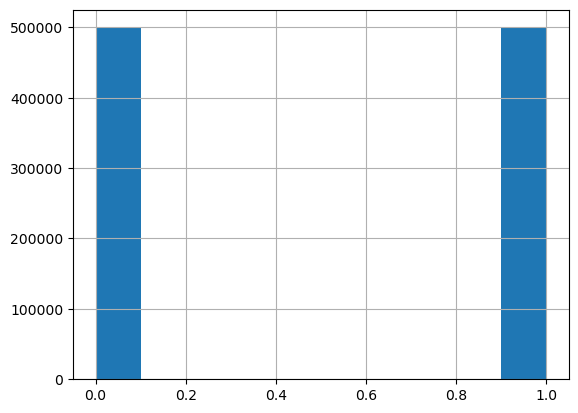

In [8]:
y.hist()

In [9]:
X.isna().sum()

f1    50067
f2    50116
f3    50196
f4    49556
f5    49851
f6    50017
dtype: int64

Explainations...

Explain your gameplan...

In [10]:
import pandas as pd

# class distribution in target
class_distribution = X['f6'].value_counts()

# minimum class count
min_class_count = class_distribution.min()

In [11]:
# equal number of records from each class
balanced_subset = pd.concat([X[X['f6'] == cls].sample(min_class_count, replace=False) for cls in class_distribution.index])

In [12]:
balanced_subset = balanced_subset.sample(frac=0.001, random_state=42)

print(balanced_subset['f6'].value_counts())


f6
B    485
A    465
Name: count, dtype: int64


In [13]:
balanced_subset.describe()

,f1,f2,f3,f4,f5
count,899.000000,910.000000,897.000000,915.000000,905.000000
mean,3.035389,2.616582,-6.792968,-0.021924,0.003608
std,4.431983,3.617576,1424.232992,1.652882,1.615553
min,0.000005,0.000008,-3213.539187,-4.992041,-4.708677
25%,0.320912,0.313884,-1100.706008,-1.206944,-1.162565
50%,1.351132,1.390440,-389.312685,0.013000,-0.006811
75%,3.907197,3.403093,998.618126,1.148429,1.111048
max,35.990895,34.886037,5437.453987,5.940324,5.349238


<Axes: >

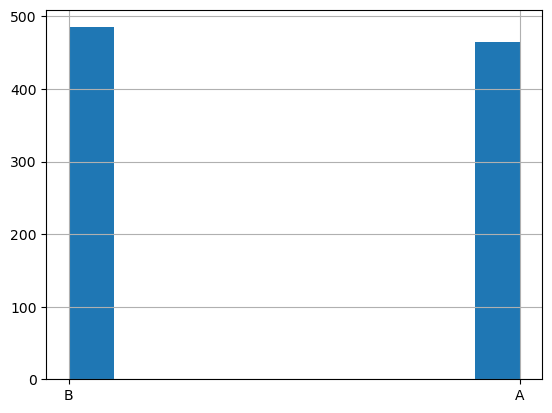

In [14]:
balanced_subset['f6'].hist()

In [15]:
# Define preprocessing pipeline
processing_pipeline = ColumnTransformer([
    ('imputer', SimpleImputer(strategy='median'), ['f1', 'f2', 'f3', 'f4', 'f5']),
    ('scaler', StandardScaler(), ['f1', 'f2', 'f3', 'f4', 'f5']),
    ('encoder', OneHotEncoder(), ['f6'])
])
processing_pipeline

ColumnTransformer(transformers=[('imputer', SimpleImputer(strategy='median'),
                                 ['f1', 'f2', 'f3', 'f4', 'f5']),
                                ('scaler', StandardScaler(),
                                 ['f1', 'f2', 'f3', 'f4', 'f5']),
                                ('encoder', OneHotEncoder(), ['f6'])])

In [16]:
balanced_subset['f6']

568124    B
420254    A
44021     A
865       B
245946    B
         ..
372678    A
434596    A
343515    A
638332    A
153298    B
Name: f6, Length: 950, dtype: object

In [17]:
y = balanced_subset['f6']
X = balanced_subset[['f1','f2', 'f3','f4','f5','f6']]

In [18]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


## HW

In [19]:
dt_modeling_pipeline = Pipeline([
    ('data_processing', processing_pipeline),
    ('ml', DecisionTreeClassifier())]
)
dt_modeling_pipeline

Pipeline(steps=[('data_processing',
                 ColumnTransformer(transformers=[('imputer',
                                                  SimpleImputer(strategy='median'),
                                                  ['f1', 'f2', 'f3', 'f4',
                                                   'f5']),
                                                 ('scaler', StandardScaler(),
                                                  ['f1', 'f2', 'f3', 'f4',
                                                   'f5']),
                                                 ('encoder', OneHotEncoder(),
                                                  ['f6'])])),
                ('ml', DecisionTreeClassifier())])

In [42]:
dt_param_grid = [
    {'dt__max_depth': [2, 4, 6, 8, 10, 12],
     'dt__min_samples_leaf': [5, 10, 20, 50, 100],
     'dt__min_samples_split': [5, 10, 15, 25]
              }
]

scoring ='Accuracy'

dt_gc = GridSearchCV(estimator=dt_modeling_pipeline, param_grid=dt_param_grid, cv=5, scoring=scoring)
dt_gcv_results = dt_gc.fit(X_train, y_train)

InvalidParameterError: The 'scoring' parameter of GridSearchCV must be a str among {'jaccard_weighted', 'f1', 'v_measure_score', 'recall_weighted', 'neg_negative_likelihood_ratio', 'max_error', 'fowlkes_mallows_score', 'precision', 'precision_macro', 'f1_weighted', 'jaccard_macro', 'precision_micro', 'roc_auc_ovr', 'top_k_accuracy', 'precision_samples', 'neg_root_mean_squared_error', 'roc_auc_ovo_weighted', 'explained_variance', 'precision_weighted', 'neg_log_loss', 'jaccard_samples', 'homogeneity_score', 'recall_macro', 'roc_auc', 'adjusted_mutual_info_score', 'f1_samples', 'jaccard', 'neg_median_absolute_error', 'neg_mean_squared_log_error', 'recall', 'balanced_accuracy', 'adjusted_rand_score', 'jaccard_micro', 'rand_score', 'roc_auc_ovo', 'neg_mean_poisson_deviance', 'neg_mean_gamma_deviance', 'f1_micro', 'neg_mean_absolute_error', 'matthews_corrcoef', 'normalized_mutual_info_score', 'average_precision', 'positive_likelihood_ratio', 'roc_auc_ovr_weighted', 'neg_brier_score', 'completeness_score', 'f1_macro', 'recall_micro', 'r2', 'recall_samples', 'mutual_info_score', 'neg_mean_squared_error', 'accuracy', 'neg_mean_absolute_percentage_error'}, a callable, an instance of 'list', an instance of 'tuple', an instance of 'dict' or None. Got 'Accuracy' instead.

In [35]:
from tqdm import tqdm


In [38]:
def fit_with_progress(estimator, param_grid, X_train, y_train, cv=5, scoring=None):
    total_iterations = len(param_grid) * cv
    progress_bar = tqdm(total=total_iterations, desc="Grid Search Progress", unit="iteration")

    # Wrap the fit method to update the progress bar
    def update_progress(*args, **kwargs):
        progress_bar.update()

    # Set the progress callback
    estimator.fit = update_progress

    # Run the grid search
    grid_search = GridSearchCV(estimator=estimator, param_grid=param_grid, cv=cv, scoring=scoring)
    results = grid_search.fit(X_train, y_train)

    # Close the progress bar after completion
    progress_bar.close()

    return results

In [37]:
dt_gcv_results = fit_with_progress(dt_modeling_pipeline, dt_param_grid, X_train, y_train, scoring=scoring)


Grid Search Progress:   0%|                                                              | 0/15 [00:00<?, ?iteration/s]

ValueError: Invalid parameter 'dt' for estimator Pipeline(steps=[('data_processing',
                 ColumnTransformer(transformers=[('imputer',
                                                  SimpleImputer(strategy='median'),
                                                  ['f1', 'f2', 'f3', 'f4',
                                                   'f5']),
                                                 ('scaler', StandardScaler(),
                                                  ['f1', 'f2', 'f3', 'f4',
                                                   'f5']),
                                                 ('encoder', OneHotEncoder(),
                                                  ['f6'])])),
                ('ml', DecisionTreeClassifier())]). Valid parameters are: ['memory', 'steps', 'verbose'].

In [ ]:
#dt_gc = GridSearchCV(estimator=dt_modeling_pipeline, param_grid=dt_param_grid, cv=5, scoring=scoring)
#dt_gcv_results = dt_gc.fit(X_train, y_train)

In [25]:
dt_gcv_results.best_params_

{'ml__max_depth': None, 'ml__min_samples_leaf': 1, 'ml__min_samples_split': 2}

In [26]:
dt_gcv_results.score(X_train, y_train)

1.0

In [27]:
dt_gcv_results.score(X_test, y_test)

1.0

Explain __shortly__ your findings how did you address the issues.

In [28]:
rf_modeling_pipeline = Pipeline([
    ('data_processing', processing_pipeline),
    ('ml', RandomForestClassifier())]
)
rf_modeling_pipeline

Pipeline(steps=[('data_processing',
                 ColumnTransformer(transformers=[('imputer',
                                                  SimpleImputer(strategy='median'),
                                                  ['f1', 'f2', 'f3', 'f4',
                                                   'f5']),
                                                 ('scaler', StandardScaler(),
                                                  ['f1', 'f2', 'f3', 'f4',
                                                   'f5']),
                                                 ('encoder', OneHotEncoder(),
                                                  ['f6'])])),
                ('ml', RandomForestClassifier())])

In [29]:
rf_param_grid = [
    {

    }
]

scoring = '??'

rf_gc = GridSearchCV(estimator=rf_modeling_pipeline, param_grid=rf_param_grid, cv=5, scoring=scoring)
rf_gcv_results = rf_gc.fit(X_train, y_train)

InvalidParameterError: The 'scoring' parameter of GridSearchCV must be a str among {'jaccard_weighted', 'f1', 'v_measure_score', 'recall_weighted', 'neg_negative_likelihood_ratio', 'max_error', 'fowlkes_mallows_score', 'precision', 'precision_macro', 'f1_weighted', 'jaccard_macro', 'precision_micro', 'roc_auc_ovr', 'top_k_accuracy', 'precision_samples', 'neg_root_mean_squared_error', 'roc_auc_ovo_weighted', 'explained_variance', 'precision_weighted', 'neg_log_loss', 'jaccard_samples', 'homogeneity_score', 'recall_macro', 'roc_auc', 'adjusted_mutual_info_score', 'f1_samples', 'jaccard', 'neg_median_absolute_error', 'neg_mean_squared_log_error', 'recall', 'balanced_accuracy', 'adjusted_rand_score', 'jaccard_micro', 'rand_score', 'roc_auc_ovo', 'neg_mean_poisson_deviance', 'neg_mean_gamma_deviance', 'f1_micro', 'neg_mean_absolute_error', 'matthews_corrcoef', 'normalized_mutual_info_score', 'average_precision', 'positive_likelihood_ratio', 'roc_auc_ovr_weighted', 'neg_brier_score', 'completeness_score', 'f1_macro', 'recall_micro', 'r2', 'recall_samples', 'mutual_info_score', 'neg_mean_squared_error', 'accuracy', 'neg_mean_absolute_percentage_error'}, a callable, an instance of 'list', an instance of 'tuple', an instance of 'dict' or None. Got '??' instead.

In [ ]:
rf_gcv_results.best_params_

In [ ]:
rf_gcv_results.score(X_train, y_train)

In [ ]:
rf_gcv_results.score(X_test, y_test)

Explain __shortly__ your findings how did you address the issues.

Explain which model would you go with?

In [ ]:
# create a new pipeline with the winner model and the best params
# evaluate the same results

Explain results